# Homework 2 - IEEE Fraud Detection

For all parts below, answer all parts as shown in the Google document for Homework 2. Be sure to include both code that justifies your answer as well as text to answer the questions. We also ask that code be commented to make it easier to follow.

## Part 1 - Fraudulent vs Non-Fraudulent Transaction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm

import datetime
import re 

#loading the train and test data into dataframe from identity and transaction files
train_identity = pd.read_csv(r"C:\Users\visha\Desktop\MS courses\DSF\train_identity.csv");
train_transaction = pd.read_csv(r"C:\Users\visha\Desktop\MS courses\DSF\train_transaction.csv");
test_identity = pd.read_csv(r"C:\Users\visha\Desktop\MS courses\DSF\test_identity.csv");
test_transaction = pd.read_csv(r"C:\Users\visha\Desktop\MS courses\DSF\test_transaction.csv");

#joining the identity and transaction dataframes into a single dataframe on the common column TransactionID
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

#reducing the memory usage before using the dataframes for plotting and modelling
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

#memory reduced dataframes
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

#deleting the dataframes which are not required to free up the memory
del train_identity, train_transaction, test_identity, test_transaction

#taking columns as specified for first 5 questions of the assignment

train_subset = train[['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'addr1', 'addr2', 'dist1', 'dist2', 'DeviceType', 'DeviceInfo']]

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


In [2]:
#getting what all columns are categorical in the dataframe, rest are numerical ones
cat_cols = list(train_subset.select_dtypes(include=['object']).columns)
cat_cols

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'DeviceType',
 'DeviceInfo']

In [3]:
#getting how many rows for the given columns have null values
train_subset.isnull().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card4               1577
card6               1571
P_emaildomain      94456
R_emaildomain     453249
addr1              65706
addr2              65706
dist1             352271
dist2             552913
DeviceType        449730
DeviceInfo        471874
dtype: int64

In [4]:
#data pre-processing where we set the null values with some meaningful ones as well as derive additional meaningful columns from the existing ones

#converting the TransactionDT into month, week, day, hour and day of the week with reference as 2017/11/30
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
def setTime(df):
    df['TransactionDT'] = df['TransactionDT'].fillna(df['TransactionDT'].median())
    # Temporary
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_M'] = (df['DT'].dt.year-2017)*12 + df['DT'].dt.month
    df['DT_W'] = (df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear
    df['DT_D'] = (df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day
    
    return df

train_subset = setTime(train_subset)

#aggregating different email address extensions into domains
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other',
          'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft',
          'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other',
          'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo',
          'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo',
          'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo',
          'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo',
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other',
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple',
          'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other',
          'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    train_subset[c + '_bin'] = train_subset[c].map(emails)
    train_subset[c + '_bin'] = train_subset[c].map(emails)
    
    train_subset[c + '_suffix'] = train_subset[c].map(lambda x: str(x).split('.')[-1])
    train_subset[c + '_suffix'] = train_subset[c].map(lambda x: str(x).split('.')[-1])
    
    train_subset[c + '_suffix'] = train_subset[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    train_subset[c + '_suffix'] = train_subset[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    

p = 'P_emaildomain'
r = 'R_emaildomain'
uknown = 'email_not_provided'

def setDomain(df):
    df[p] = df[p].fillna(uknown)
    df[r] = df[r].fillna(uknown)
    
    # Check if P_emaildomain matches R_emaildomain
    df['email_check'] = np.where((df[p]==df[r])&(df[p]!=uknown),1,0)

    df[p+'_prefix'] = df[p].apply(lambda x: x.split('.')[0])
    df[r+'_prefix'] = df[r].apply(lambda x: x.split('.')[0])
    
    return df
    
train_subset = setDomain(train_subset)

#Filling zeroes for numerical columns addr1, addr2, dist1, dist2
train_subset["dist1"].fillna(value=0, inplace = True)
train_subset["dist2"].fillna(value=0, inplace = True)
train_subset["addr1"].fillna(value=0, inplace = True)
train_subset["addr2"].fillna(value=0, inplace = True)

#Filling unknown in place of NAs for categorical columns card4, card6
train_subset["card4"].fillna(value='unknown', inplace = True)
train_subset["card6"].fillna(value='unknown', inplace = True)

#Marking rows with null values for DeviceType with unknown
train_subset["DeviceType"].fillna(value='unknown', inplace = True)

C:\Users\visha\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\visha\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\visha\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

AttributeError: 'DataFrame' object has no attribute 'device_name'

In [8]:
#Aggregating various device models of the same company for better visualisation into a new column DeviceName
def setDevice(df):
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    
    df['DeviceName'] = df['DeviceInfo'].str.split('/', expand=True)[0]

    df.loc[df['DeviceName'].str.contains('SM', na=False, flags=re.IGNORECASE), 'DeviceName'] = 'Samsung'
    df.loc[df['DeviceName'].str.contains('sm', na=False, flags=re.IGNORECASE), 'DeviceName'] = 'Samsung'
    df.loc[df['DeviceName'].str.contains('SAMSUNG', na=False, flags=re.IGNORECASE), 'DeviceName'] = 'Samsung'
    df.loc[df['DeviceName'].str.contains('GT-', na=False, flags=re.IGNORECASE), 'DeviceName'] = 'Samsung'
    df.loc[df['DeviceName'].str.contains('Moto G', na=False, flags=re.IGNORECASE), 'DeviceName'] = 'Motorola'
    df.loc[df['DeviceName'].str.contains('Moto', na=False, flags=re.IGNORECASE), 'DeviceName'] = 'Motorola'
    df.loc[df['DeviceName'].str.contains('moto', na=False, flags=re.IGNORECASE), 'DeviceName'] = 'Motorola'
    df.loc[df['DeviceName'].str.contains('LG-', na=False, flags=re.IGNORECASE), 'DeviceName'] = 'LG'
    df.loc[df['DeviceName'].str.contains('rv:', na=False, flags=re.IGNORECASE), 'DeviceName'] = 'RV'
    df.loc[df['DeviceName'].str.contains('HUAWEI', na=False, flags=re.IGNORECASE), 'DeviceName'] = 'Huawei'
    df.loc[df['DeviceName'].str.contains('ALE-', na=False, flags=re.IGNORECASE), 'DeviceName'] = 'Huawei'
    df.loc[df['DeviceName'].str.contains('-L', na=False, flags=re.IGNORECASE), 'DeviceName'] = 'Huawei'
    df.loc[df['DeviceName'].str.contains('Blade', na=False, flags=re.IGNORECASE), 'DeviceName'] = 'ZTE'
    df.loc[df['DeviceName'].str.contains('BLADE', na=False, flags=re.IGNORECASE), 'DeviceName'] = 'ZTE'
    df.loc[df['DeviceName'].str.contains('Linux', na=False, flags=re.IGNORECASE), 'DeviceName'] = 'Linux'
    df.loc[df['DeviceName'].str.contains('XT', na=False, flags=re.IGNORECASE), 'DeviceName'] = 'Sony'
    df.loc[df['DeviceName'].str.contains('HTC', na=False, flags=re.IGNORECASE), 'DeviceName'] = 'HTC'
    df.loc[df['DeviceName'].str.contains('ASUS', na=False, flags=re.IGNORECASE), 'DeviceName'] = 'Asus'

    df.loc[df.DeviceName.isin(df.DeviceName.value_counts()[df.DeviceName.value_counts() < 200].index), 'DeviceName'] = "Others"
    
    return df

train_subset = setDevice(train_subset)

#filtering out fraud transactions with the non-fraud ones for plotting
train_subset_is_fraud = train_subset[train_subset.isFraud == 1]
train_subset_is_not_fraud = train_subset[train_subset.isFraud == 0]

C:\Users\visha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\visha\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [11]:
print(train_subset_is_fraud.shape)
print(train_subset_is_not_fraud.shape)

(20663, 30)
(569877, 30)


As is evident above, we have a huge number of records for non fraudulent transactions as compared to fraudulent ones. So for plotting purposes, we might have to take log when when plotting non-fraudulent ones separately as well as compare the percentage values for each column when we plot both types together.

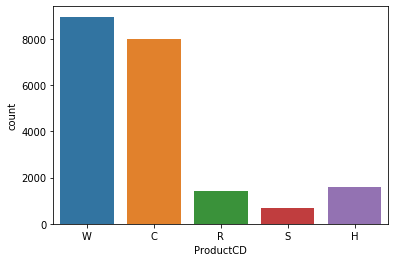

In [12]:
sns.countplot(x="ProductCD", data=train_subset_is_fraud)

Among the fraudulent transactions, there are highest counts for category W followed by C. S has the least count while R and H have almost equal counts.

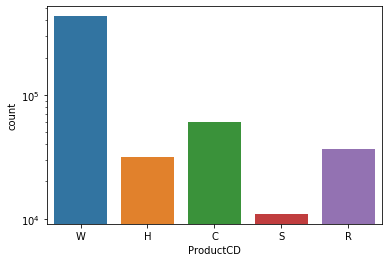

In [13]:
g = sns.countplot(x="ProductCD", data=train_subset_is_not_fraud)
g.set_yscale('log')

Among the non-fraudulent transactions, W counts for 75% followed by C at 10%. S has the least count while R and H have almost equal counts.

In [15]:
not_fraud_perc = train_subset_is_not_fraud['ProductCD'].value_counts(normalize=True) * 100
fraud_perc = train_subset_is_fraud['ProductCD'].value_counts(normalize=True) * 100

In [16]:
not_fraud_perc

W    75.577888
C    10.618256
R     6.365058
H     5.518735
S     1.920063
Name: ProductCD, dtype: float64

In [17]:

fraud_perc

W    43.406088
C    38.755263
H     7.617481
R     6.901224
S     3.319944
Name: ProductCD, dtype: float64

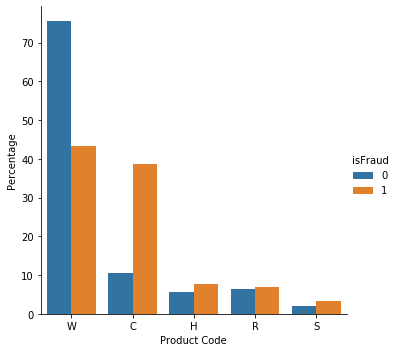

In [18]:
a = pd.DataFrame(({'Product Code':fraud_perc.index, 'Percentage':fraud_perc.values}))
a['isFraud'] = [1,1,1,1,1]
b = pd.DataFrame(({'Product Code':not_fraud_perc.index, 'Percentage':not_fraud_perc.values}))
b['isFraud'] = [0,0,0,0,0]
df = pd.concat([a,b], axis = 0)
sns.catplot(x='Product Code', y='Percentage', hue='isFraud', data=df, kind='bar')

Only for product code W, percentage of non-fraud ones is higher than the fraud ones. Rest of the codes have higher percentage for fraud ones meaning the codes C, H, R and S are more frequent in the fraud transactions as compared to non-fraud ones.

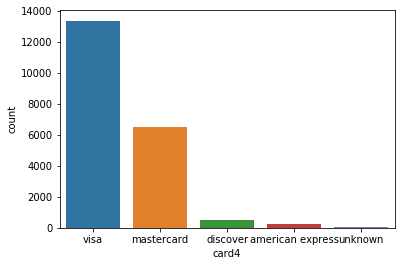

In [19]:
sns.countplot(x="card4", data=train_subset_is_fraud)

For card4(Card Issuer), Visa has almost double the count of fraud transactions as compared to Mastercard. This might be due to the fact that Visa users are more as compared to Mastercard ones. Also, Discover and American Express are used by few people and hence have a lower percent of fraud transactions. 

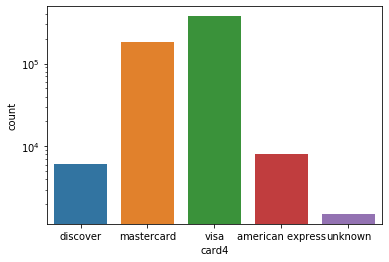

In [20]:
g = sns.countplot(x="card4", data=train_subset_is_not_fraud)
g.set_yscale('log')

The observation here is the same except for the fact that non-fraud transactions for American Express is higher than Discover which was not the case for fraud ones.

In [ ]:
not_fraud_perc = train_subset_is_not_fraud['card4'].value_counts(normalize=True) * 100
fraud_perc = train_subset_is_fraud['card4'].value_counts(normalize=True) * 100

In [21]:
not_fraud_perc

W    75.577888
C    10.618256
R     6.365058
H     5.518735
S     1.920063
Name: ProductCD, dtype: float64

In [22]:
fraud_perc

W    43.406088
C    38.755263
H     7.617481
R     6.901224
S     3.319944
Name: ProductCD, dtype: float64

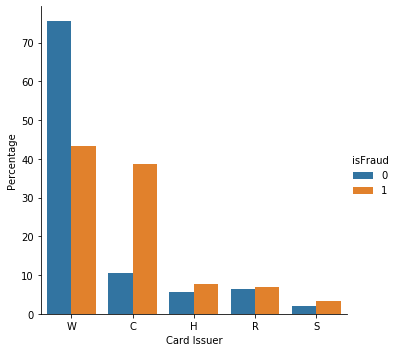

In [24]:
a = pd.DataFrame(({'Card Issuer':fraud_perc.index, 'Percentage':fraud_perc.values}))
a['isFraud'] = [1,1,1,1,1]
b = pd.DataFrame(({'Card Issuer':not_fraud_perc.index, 'Percentage':not_fraud_perc.values}))
b['isFraud'] = [0,0,0,0,0]
df = pd.concat([a,b], axis = 0)
sns.catplot(x='Card Issuer', y='Percentage', hue='isFraud', data=df, kind='bar')

For fraud vs non-fraud, percentage trend is the same for Visa and Mastercard i.e they both have almost same probability of being in the fraud and non-fraud transactions.

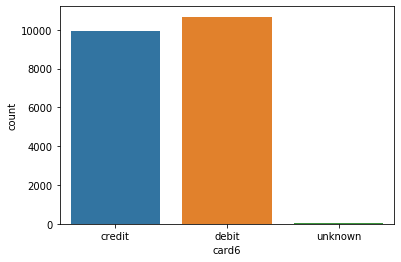

In [25]:
sns.countplot(x="card6", data=train_subset_is_fraud)

Among the fraudulent ones, count for debit is more than credit cards. Same is the case for non-fraud ones also. One of the reason for this might be because debit cards are used more than the credit ones as the credit card issuers have some rules for a person's background before they issue a credit card whereas debit cards are issued without any strict checks.

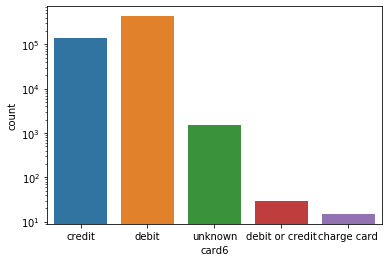

In [26]:
g = sns.countplot(x="card6", data=train_subset_is_not_fraud)
g.set_yscale('log')

In [27]:
not_fraud_perc = train_subset_is_not_fraud['card6'].value_counts(normalize=True) * 100
fraud_perc = train_subset_is_fraud['card6'].value_counts(normalize=True) * 100

In [28]:
fraud_perc

debit      51.657552
credit     48.153705
unknown     0.188743
Name: card6, dtype: float64

In [29]:
not_fraud_perc

debit              75.325728
credit             24.397545
unknown             0.268830
debit or credit     0.005264
charge card         0.002632
Name: card6, dtype: float64

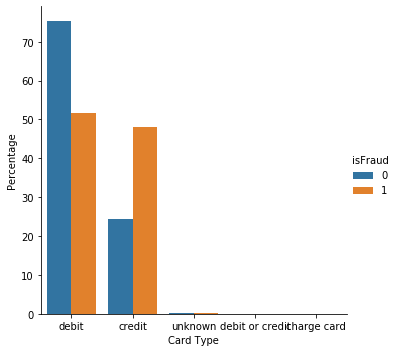

In [31]:
a = pd.DataFrame(({'Card Type':fraud_perc.index, 'Percentage':fraud_perc.values}))
a = a.append({'Card Type' : 'debit or credit' , 'Percentage' : 0} , ignore_index=True)
a = a.append({'Card Type' : 'charge card' , 'Percentage' : 0} , ignore_index=True)
a['isFraud'] = [1,1,1,1,1]
b = pd.DataFrame(({'Card Type':not_fraud_perc.index, 'Percentage':not_fraud_perc.values}))
b['isFraud'] = [0,0,0,0,0]
df = pd.concat([a,b], axis = 0)
g = sns.catplot(x='Card Type', y='Percentage', hue='isFraud', data=df, kind='bar')

The percentage calculation as well as the plot shows that usually fraudulent transactions occur more with credit cards than debit cards. Frauds do occur with debit cards too but with a lesser probability. For credit cards, frauds occur almost in 2 transactions out of 3.

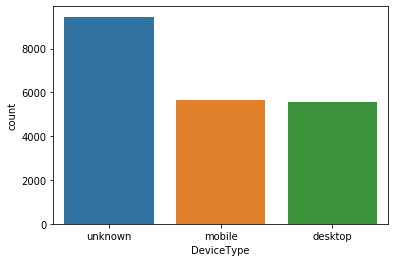

In [32]:
sns.countplot(x="DeviceType", data=train_subset_is_fraud)

For the attribute device type, a huge number of transactions are from unknown devices. this might be due to the fact that people using those devices might not have given the permission to collect data about their devices. AMong the fraud ones, transactions happen with almost same percentages by desktop and mobile.

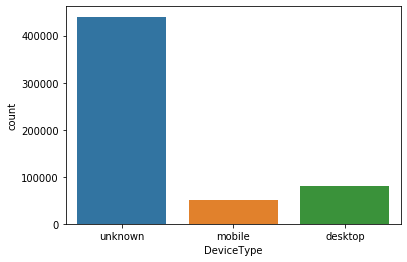

In [33]:
sns.countplot(x="DeviceType", data=train_subset_is_not_fraud)

In [ ]:
Among the non-fraud ones, desktop has higher percentage than mobile devices.

In [35]:
not_fraud_perc = train_subset_is_not_fraud['DeviceType'].value_counts(normalize=True) * 100
fraud_perc = train_subset_is_fraud['DeviceType'].value_counts(normalize=True) * 100

In [36]:
not_fraud_perc

unknown    77.258426
desktop    13.969857
mobile      8.771717
Name: DeviceType, dtype: float64

In [37]:
fraud_perc

unknown    45.743600
mobile     27.377438
desktop    26.878962
Name: DeviceType, dtype: float64

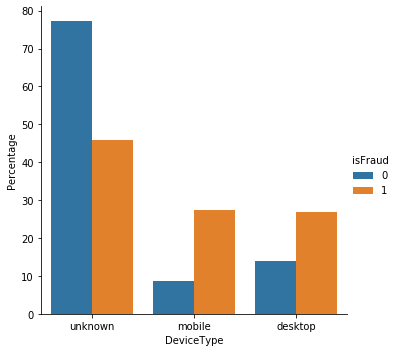

In [38]:
a = pd.DataFrame(({'DeviceType':fraud_perc.index, 'Percentage':fraud_perc.values}))
a['isFraud'] = [1,1,1]
b = pd.DataFrame(({'DeviceType':not_fraud_perc.index, 'Percentage':not_fraud_perc.values}))
b['isFraud'] = [0,0,0]
df = pd.concat([a,b], axis = 0)
g = sns.catplot(x='DeviceType', y='Percentage', hue='isFraud', data=df, kind='bar')

One interesting insight we get from the above plot is that the percentage of unknown devices is lesser in fraud ones as compared to genuine transactions which indicates that people doing fraudulent transactions might unknowingly leave some info about their devices.

In [ ]:
ax2 = plt.axes([0, 0, 2, 2])
g = sns.countplot(x="DeviceName", data=train_subset_is_fraud, ax = ax2)
g.set_yscale('log')

In [ ]:
ax2 = plt.axes([0, 0, 2, 2])
g = sns.countplot(x="DeviceName", data=train_subset_is_not_fraud, ax = ax2)
g.set_yscale('log')

In [39]:
not_fraud_perc = train_subset_is_not_fraud['DeviceName'].value_counts(normalize=True) * 100
fraud_perc = train_subset_is_fraud['DeviceName'].value_counts(normalize=True) * 100

In [40]:
fraud_perc

unknown_device    58.345836
windows           15.104293
Samsung            6.785075
ios device         6.001065
Others             4.558873
Motorola           2.163287
RV                 1.611576
Huawei             1.442191
macos              1.345400
LG                 1.176015
ZTE                0.464599
trident            0.464599
Sony               0.367807
HTC                0.169385
Name: DeviceName, dtype: float64

In [41]:
not_fraud_perc

unknown_device    80.687236
windows            7.826426
ios device         3.253685
macos              2.157483
Samsung            1.875843
trident            1.288699
Others             0.806665
RV                 0.711031
Motorola           0.436585
LG                 0.366395
Huawei             0.364816
Sony               0.087563
ZTE                0.072472
HTC                0.065102
Name: DeviceName, dtype: float64

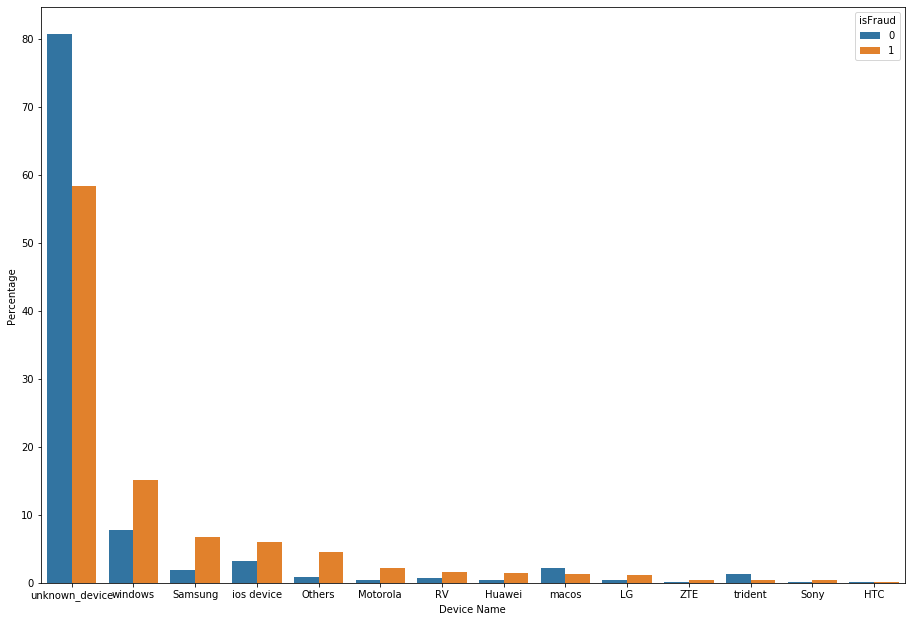

In [43]:
a = pd.DataFrame(({'Device Name':fraud_perc.index, 'Percentage':fraud_perc.values}))
a['isFraud'] = [1,1,1,1,1,1,1,1,1,1,1,1,1,1]
b = pd.DataFrame(({'Device Name':not_fraud_perc.index, 'Percentage':not_fraud_perc.values}))
b['isFraud'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]
df = pd.concat([a,b], axis = 0)
ax2 = plt.axes([0, 0, 2, 2])
sns.catplot(x='Device Name', y='Percentage', hue='isFraud', data=df, kind='bar', ax=ax2)
plt.close(2)

The percentages for unknown devices is higher in both fraud and non-fraud transactions but comparatively it's lesser for fraud ones which again indicates that people doing fraud might unknowingly leak some info about their devices. Also, fraud transactions have a higher percentage of Windows devices than non-fraud. It is then followed by iOS and Samsung while other brands have a very negligible contribution to the plot. This denotes that these brands are more in use than the other ones. 

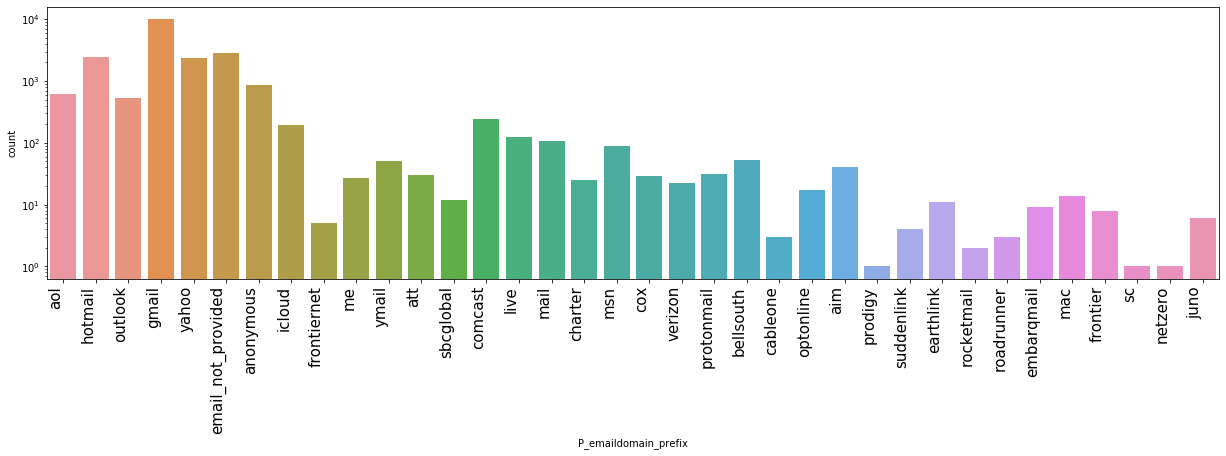

In [45]:
ax = sns.countplot(x="P_emaildomain_prefix", data=train_subset_is_fraud)
ax.set_yscale('log')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=15)
plt.rcParams["figure.figsize"] = [21, 10] 
plt.figure
plt.show()

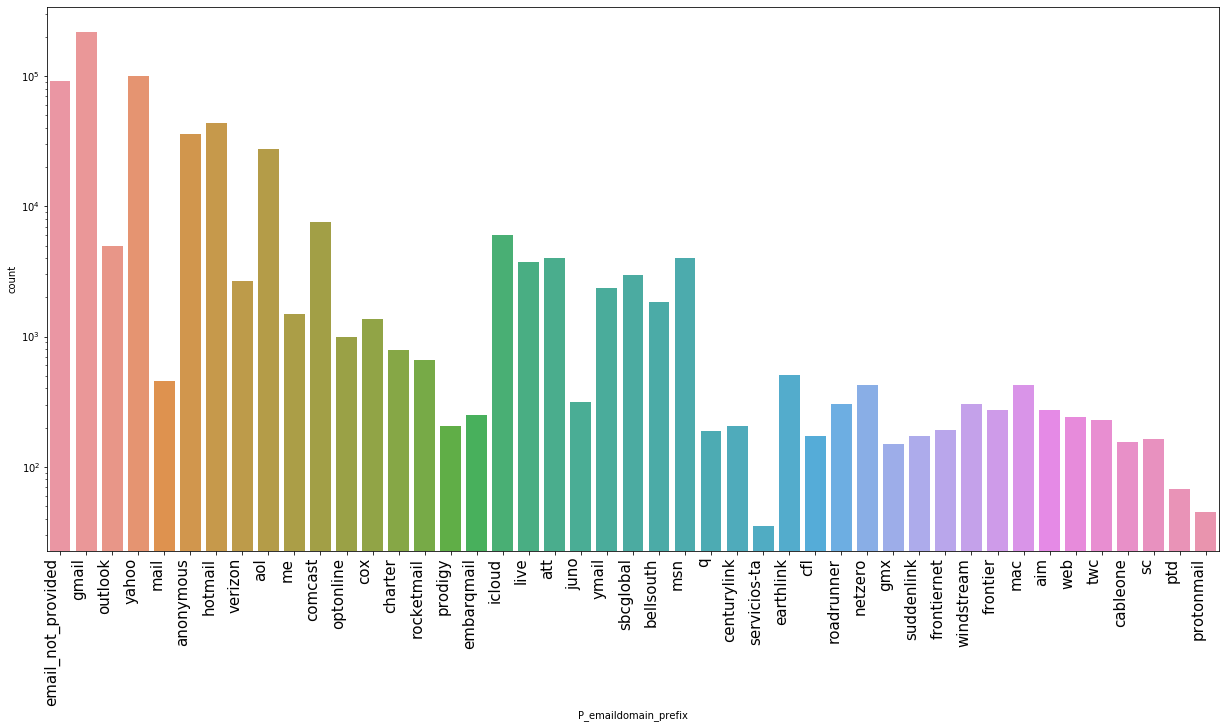

In [46]:
ax = sns.countplot(x="P_emaildomain_prefix", data=train_subset_is_not_fraud)
ax.set_yscale('log')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=15)
plt.rcParams["figure.figsize"] = [21, 10] 
plt.figure
plt.show()

Gmail is the most prominent one when it comes to sender's email domain for both fraud and non-fraud ones followed by Hotmail and Yahoo. For the fraudulent transactions, percentages for both are almost same but in the non-fraud ones, Yahoo domain has almost double the counts of transactions as compared to Hotmail domain.

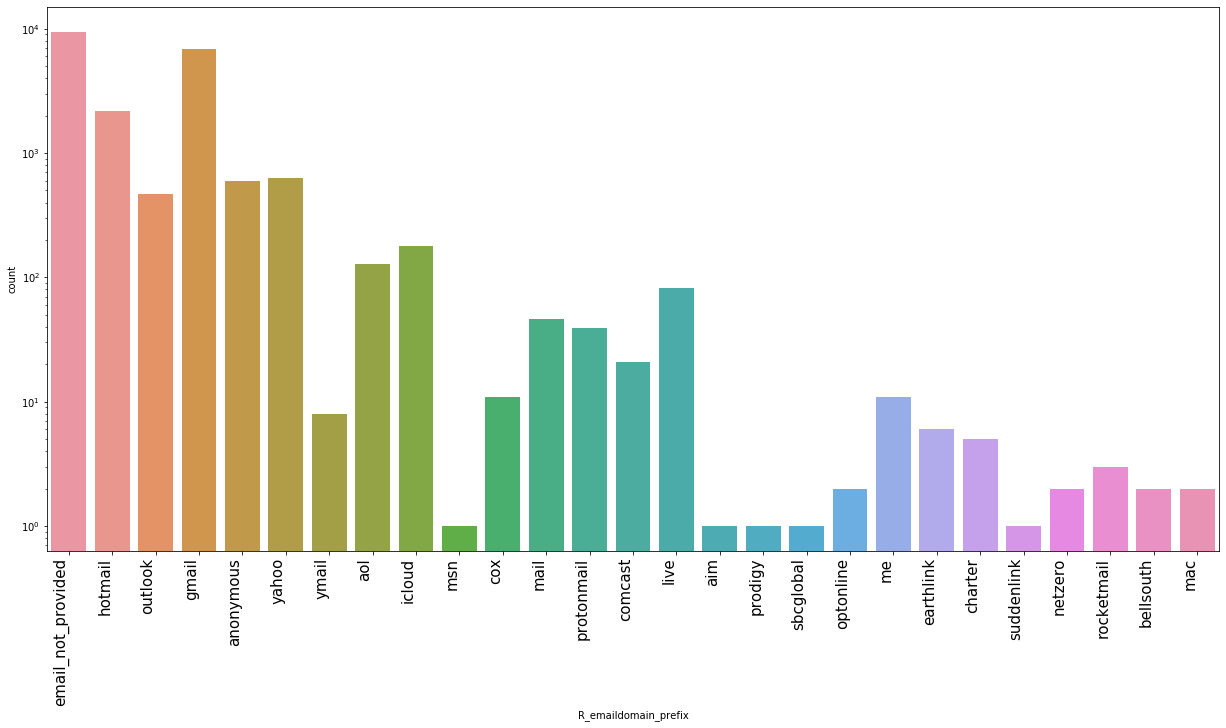

In [47]:
ax = sns.countplot(x="R_emaildomain_prefix", data=train_subset_is_fraud)
ax.set_yscale('log')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=15)
plt.rcParams["figure.figsize"] = [21, 10] 
plt.figure
plt.show()

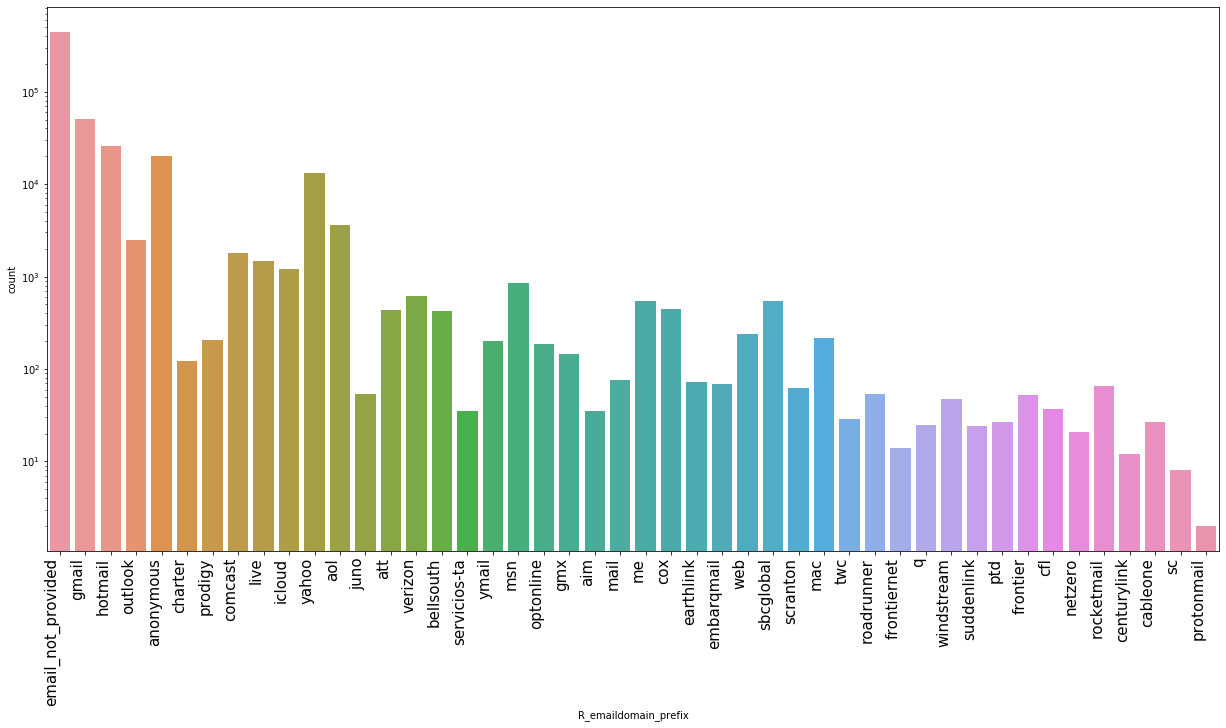

In [48]:
ax = sns.countplot(x="R_emaildomain_prefix", data=train_subset_is_not_fraud)
ax.set_yscale('log')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=15)
plt.rcParams["figure.figsize"] = [21, 10] 
plt.figure
plt.show()

If we compare the plot for receiver's email domain for non-fraud ones, 2-3 domains have a large contrbution while the rest percentage is almost equally shared by the other domains. This is not the case for fraud transactions. Here, although a major share is of domains like Hotmail, Gmail, Yahoo and Outlook, the rest of the percentage transactions are unequally divided among other domains.

## Part 2 - Transaction Frequency

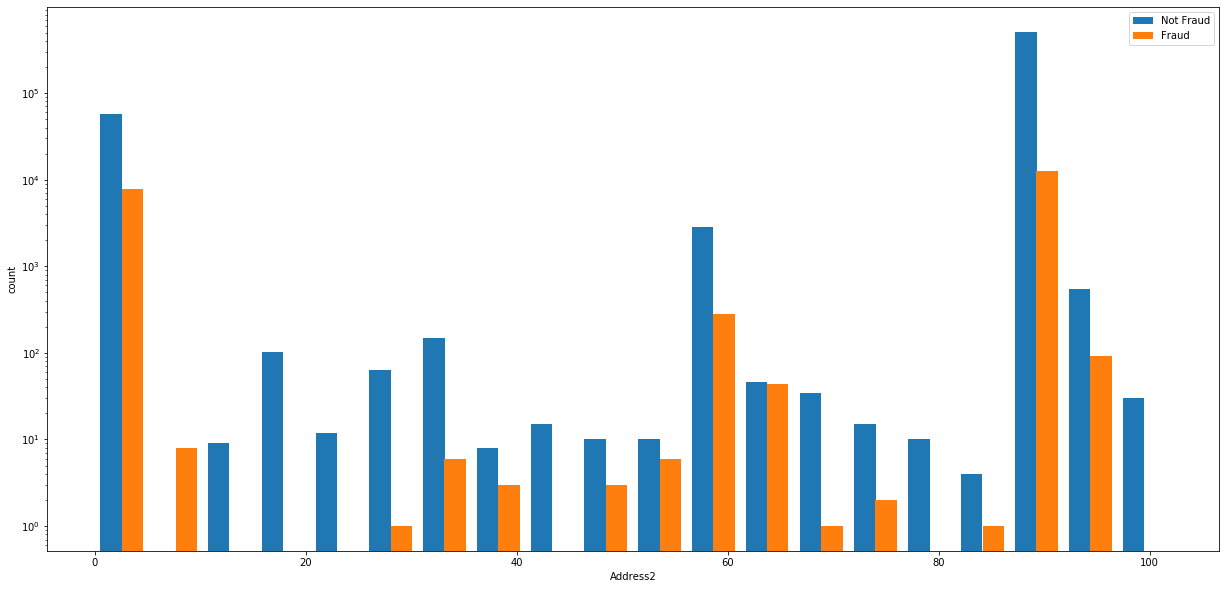

In [49]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Address2')
ax.set_ylabel('count');
ax.set_yscale('log');

_ = ax.hist((train_subset_is_not_fraud.addr2, train_subset_is_fraud.addr2), bins=20)

# Add a legend
ax.legend(('Not Fraud', 'Fraud'), loc='upper right');

(array([6.57140e+04, 1.10000e+02, 7.60000e+01, 1.66000e+02, 2.80000e+01,
        3.13000e+03, 1.25000e+02, 2.70000e+01, 5.20492e+05, 6.72000e+02]),
 array([  0. ,  10.2,  20.4,  30.6,  40.8,  51. ,  61.2,  71.4,  81.6,
         91.8, 102. ], dtype=float16),
 <a list of 10 Patch objects>)

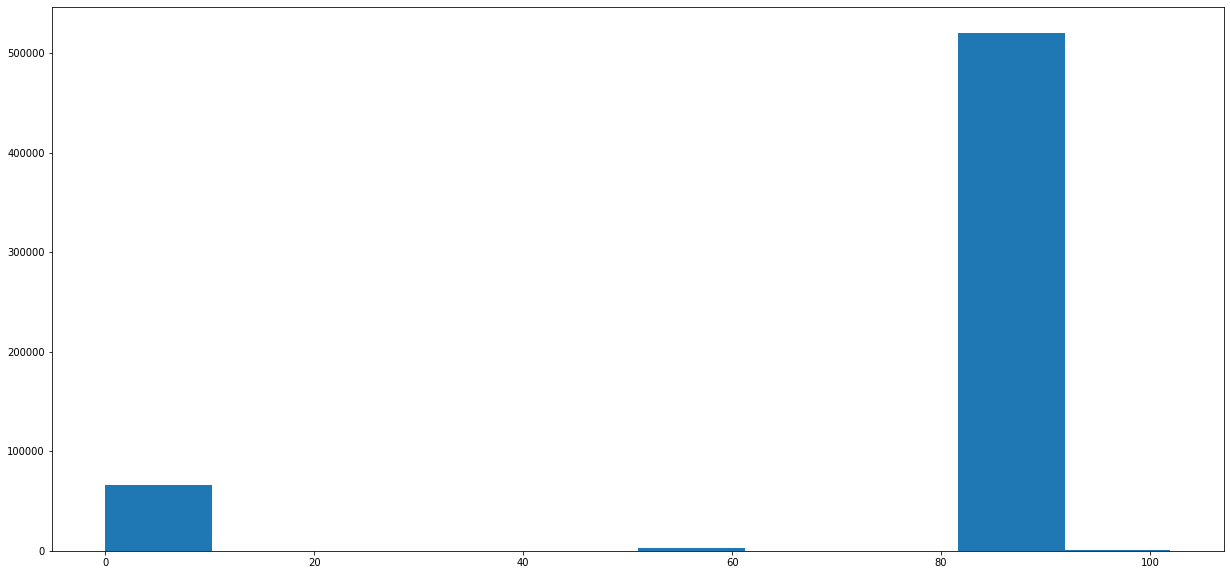

In [54]:
plt.hist(train_subset['addr2'])

The plot for addr2 field shows that there are a significantly large number of transactions from a particular country in the entire dataset. This addr2 field value equals 87 which indicates that either a large number of records were collcted from this country, or people of this country do a large number of transactions as compared to other countries.

In [55]:
hour_count = train_subset['DT_hour'].value_counts()

In [56]:
hour_count

19    42115
20    41782
21    41641
18    41639
22    41139
17    40723
23    39949
16    38698
0     37795
15    33859
1     32797
14    28328
2     26732
3     20802
13    20315
4     14839
12    12451
5      9701
11     6827
6      6007
7      3704
10     3627
8      2591
9      2479
Name: DT_hour, dtype: int64

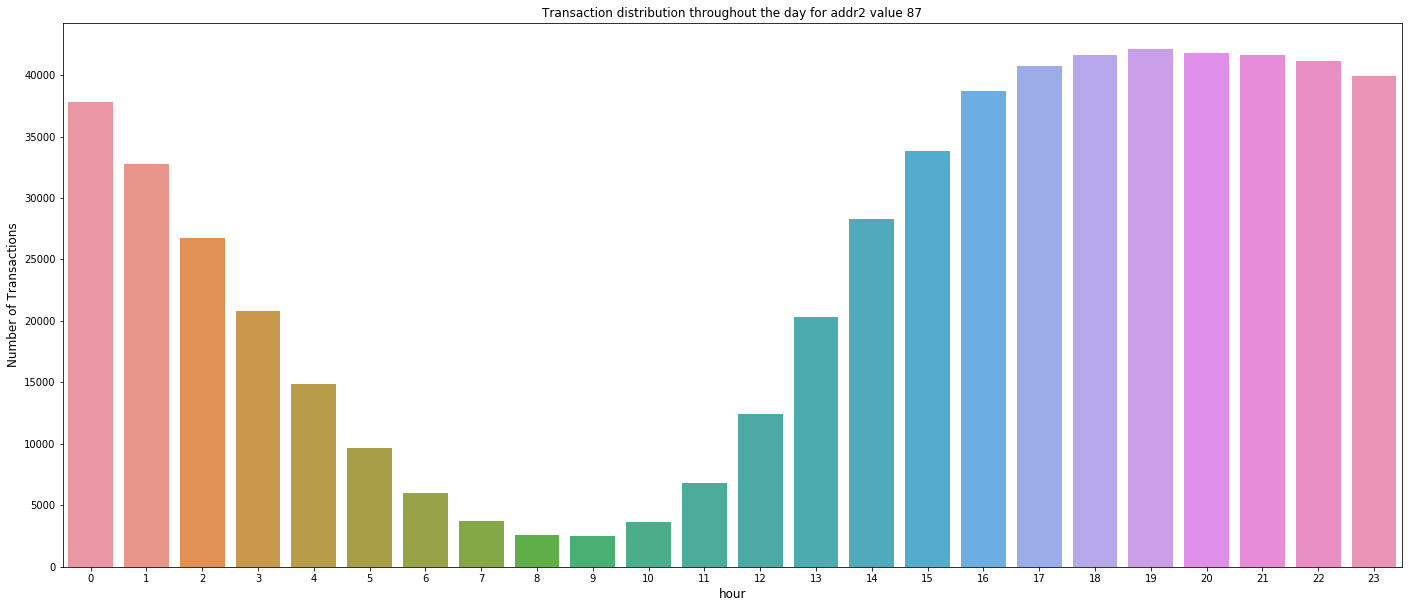

In [57]:
plt.figure(figsize=(24,10))
sns.barplot(hour_count.index, hour_count.values)
plt.title('Transaction distribution throughout the day for addr2 value 87')
plt.ylabel('Number of Transactions', fontsize=12)
plt.xlabel('hour', fontsize=12)
plt.show()

The plot of hour of the day vs the count of transactions provides an insight about the general waking hours of the country with addr2 field as 87. The plot is kind of sinusoidal and indicates that the transaction count is higher at midnight(12:00 AM) but then it goes on decreasing till 9 AM steadily. This indicates that people of this country dont transact that much between 12 AM to 9 AM as compared to other time of the day. We can infer that they might be sleeping during this time and are awake during rest of the hours. Now when we consider the hours from 10 AM to 7 PM, there is a steady increase and the count reaches its peak at 7 PM. These hours are the ones where people are awake and active and hence transact more. They might be buying things for themselves at retail stores or purchasing stuff online. From 7 PM to 11 PM, there is a decline in the transactions as compared to previous duration but then we see a rise again at 12 AM. This indicates that people do transact considerably between 11 PM to 1 AM.

## Part 3 - Product Code

In [58]:
train_subset_describe = train_subset[['ProductCD', 'TransactionAmt', 'DT_hour']]

In [59]:
print(train_subset_describe.groupby('ProductCD').TransactionAmt.describe())

              count  mean  std        min         25%       50%        75%  \
ProductCD                                                                    
C           68519.0   NaN  NaN   0.250977   18.421875   31.1875   54.09375   
H           33024.0   inf  inf  15.000000   35.000000   50.0000  100.00000   
R           37699.0   inf  inf  25.000000  100.000000  125.0000  200.00000   
S           11628.0   inf  inf   5.000000   20.000000   35.0000   80.00000   
W          439670.0   NaN  NaN   1.000000   49.000000   78.5000  146.00000   

               max  
ProductCD           
C            713.0  
H            500.0  
R           1800.0  
S           1550.0  
W          31936.0  


Clearly, the cheapest product is of the code C. C category has the lowest mean, minimum value and the percentile ranges. Although its max value is higher than H but that is because of outliers as we can see in the graph below:

(array([3.1132e+04, 2.1496e+04, 8.8110e+03, 3.3570e+03, 1.7430e+03,
        8.8800e+02, 4.5400e+02, 2.9600e+02, 1.2500e+02, 9.2000e+01,
        6.3000e+01, 1.9000e+01, 1.7000e+01, 9.0000e+00, 1.1000e+01,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([2.510e-01, 2.877e+01, 5.728e+01, 8.575e+01, 1.143e+02, 1.428e+02,
        1.712e+02, 1.999e+02, 2.284e+02, 2.568e+02, 2.852e+02, 3.138e+02,
        3.422e+02, 3.710e+02, 3.995e+02, 4.280e+02, 4.565e+02, 4.850e+02,
        5.135e+02, 5.420e+02, 5.705e+02, 5.990e+02, 6.275e+02, 6.560e+02,
        6.845e+02, 7.130e+02], dtype=float16),
 <a list of 25 Patch objects>)

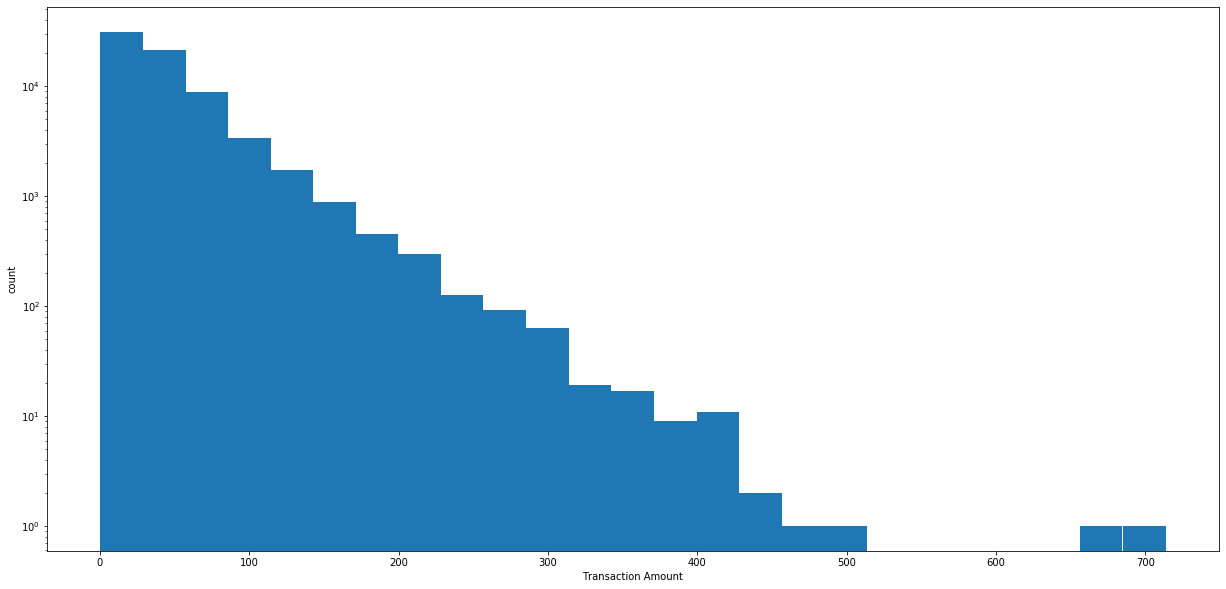

In [67]:
train_subset_describe_c = train_subset_describe[train_subset_describe.ProductCD == 'C']
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Transaction Amount')
ax.set_ylabel('count');
ax.set_yscale('log')
ax.hist(x=train_subset_describe_c.TransactionAmt, bins=25)

Finding the most expensive product category is kind of ambiguous. If we define the most expensive category as the one which has the highest item price among items of all categories, then W is the most expensive one as it has an item of price 31937.391 units.

In [68]:
train_subset_describe_w = train_subset_describe[train_subset_describe.ProductCD == 'W']
train_subset_describe_r = train_subset_describe[train_subset_describe.ProductCD == 'R']

(array([4.29158e+05, 7.23800e+03, 2.14000e+03, 9.21000e+02, 1.22000e+02,
        6.40000e+01, 2.30000e+01, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([1.0000e+00, 7.9950e+02, 1.5980e+03, 2.3960e+03, 3.1940e+03,
        3.9920e+03, 4.7920e+03, 5.5880e+03, 6.3880e+03, 7.1880e+03,
        7.9840e+03, 8.7840e+03, 9.5840e+03, 1.0376e+04, 1.1176e+04,
        1.1976e+04, 1.2776e+04, 1.3576e+04, 1.4368e+04, 1.5168e+04,
        1.5968e+04, 1.6768e+04, 1.7568e+04, 1.8368e+04, 1.9168e+04,
        1.9968e+04, 2.0752e+04, 2.1552e+04, 2.2352e+04, 2.3152e+04,
      

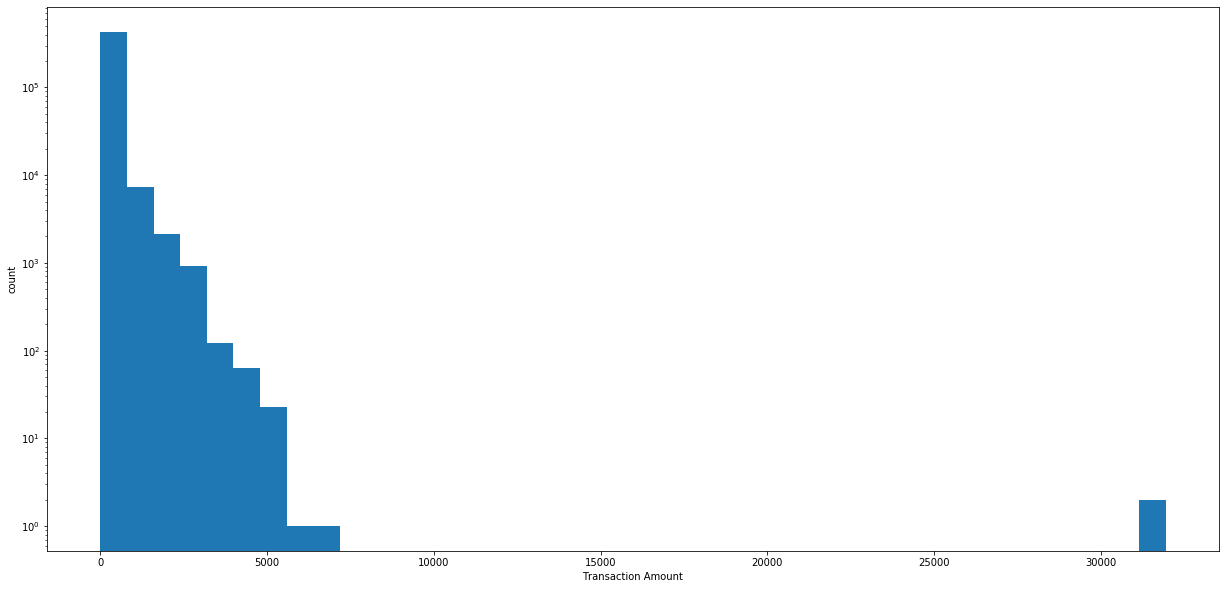

In [72]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Transaction Amount')
ax.set_ylabel('count');
ax.set_yscale('log')
ax.hist(x=train_subset_describe_w.TransactionAmt, bins=40)

Now if we want to ignore the item with price 31937.391 units of category W as an outlier and now define the most expensive category as the one which has the highest item price on an average among all categories or in other words, whose products are generally expensive, then R is the most expensive category. As we can see from the plot below, there is a high distribution of items in the price range 25 units to 1000 units. Also, there is significant item distribution in the range 1000 to 1800 units. Also, from the description table above, mean of R is the max among all categories.

(array([4.0830e+03, 1.3627e+04, 7.4210e+03, 5.5900e+03, 1.9000e+02,
        2.7650e+03, 1.5280e+03, 2.0400e+02, 5.1000e+02, 1.2100e+02,
        7.4700e+02, 2.1000e+01, 2.1800e+02, 1.3000e+01, 2.7000e+01,
        5.0000e+01, 9.7000e+01, 5.0000e+01, 1.4000e+01, 7.6000e+01,
        6.0000e+00, 2.9000e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.1000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        7.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+01, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([  25.  ,   69.4 ,  113.75,  158.1 ,  202.5 ,  246.9 ,  291.2 ,
         335.5 ,  380.  ,  424.5 ,  468.8 ,  513.  ,  557.5 ,  602.  ,
         646.  ,  690.5 ,  735.  ,  779.5 ,  824.  ,  868.  ,  912.5 ,
         957.  , 1001.  , 1046.  , 1090.  , 1134.  , 1179.  , 1223.  ,
        1268.  , 1312.  , 1356.  , 1401.  , 1445.  , 1489.  , 1534.  ,
        1578.  , 1622.  , 1667.  , 1711.  , 1756.  , 1800.  ],
       dtype=float16),
 <a list of 4

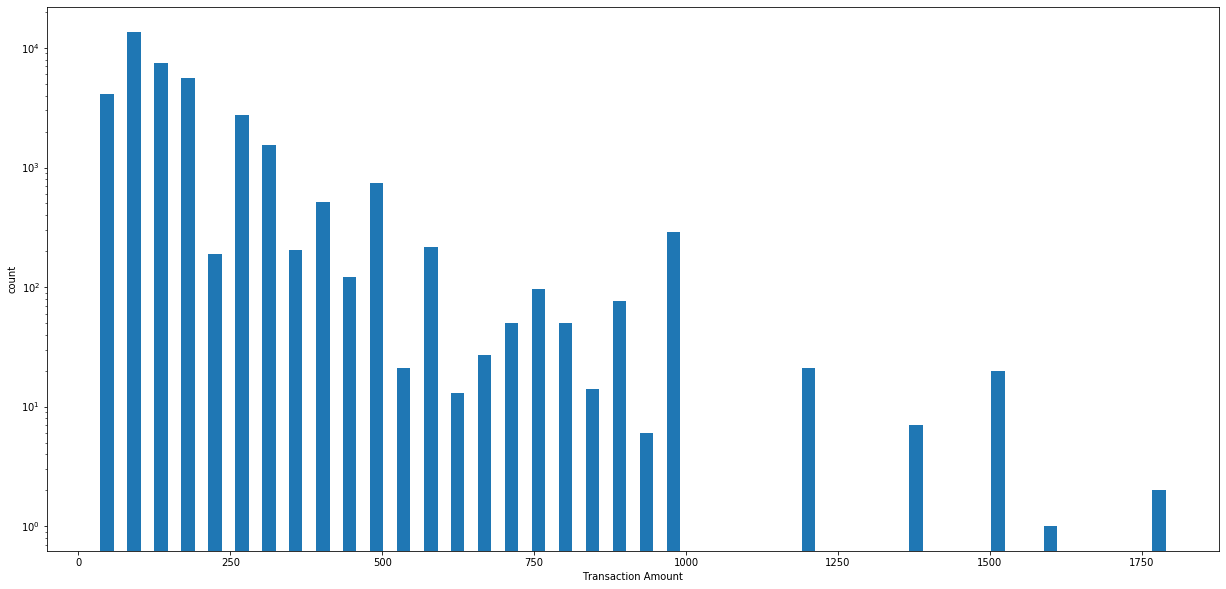

In [87]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Transaction Amount')
ax.set_ylabel('count');
ax.set_yscale('log')
ax.hist(x=train_subset_describe_r.TransactionAmt, bins=40, rwidth=0.5)

The above graph indicates that most of the transaction amount lie in the range of 0 to 1000 units

## Part 4 - Correlation Coefficient

In [4]:
train_subset['DT_hour'].corr(train['TransactionAmt'])

The correlation value between time of the day and purchase amount is 0.0445323560306529 which denotes not a strong correlation.

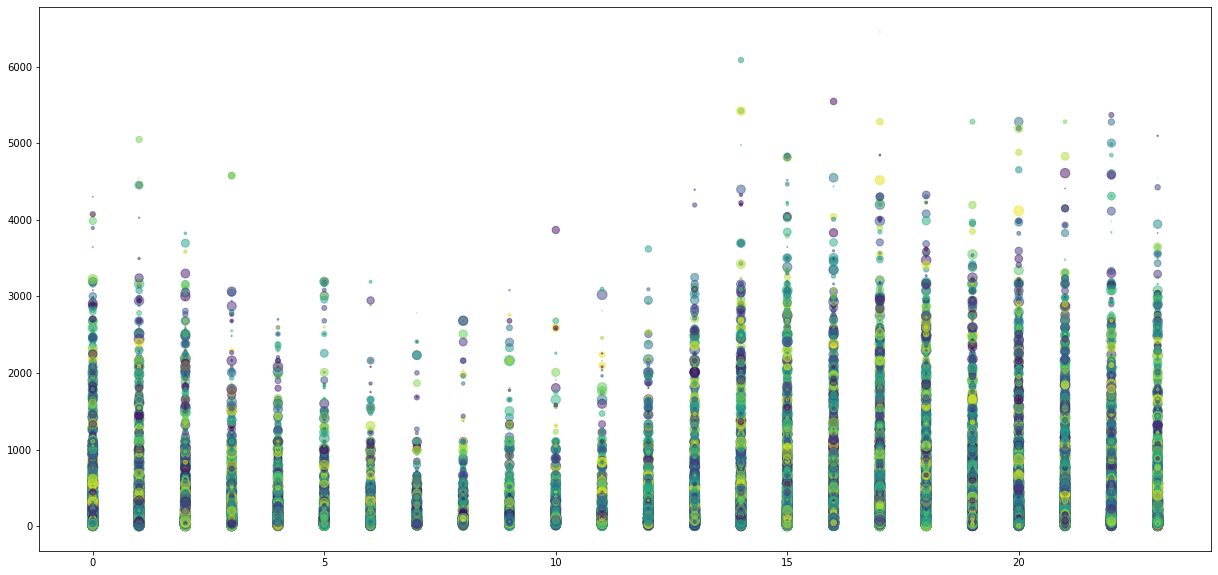

In [83]:
train_subset_without_outliers = train_subset[train_subset.TransactionAmt<30000]
N = 590538
colors = np.random.rand(N)
area = (10 * np.random.rand(N))**2
plt.scatter(train_subset_without_outliers.DT_hour, train_subset_without_outliers.TransactionAmt, s=area, c=colors, alpha=0.5)
plt.show()

## Part 5 - Interesting Plot

(array([85433., 84815., 85356., 86377., 98502., 79834., 70223.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

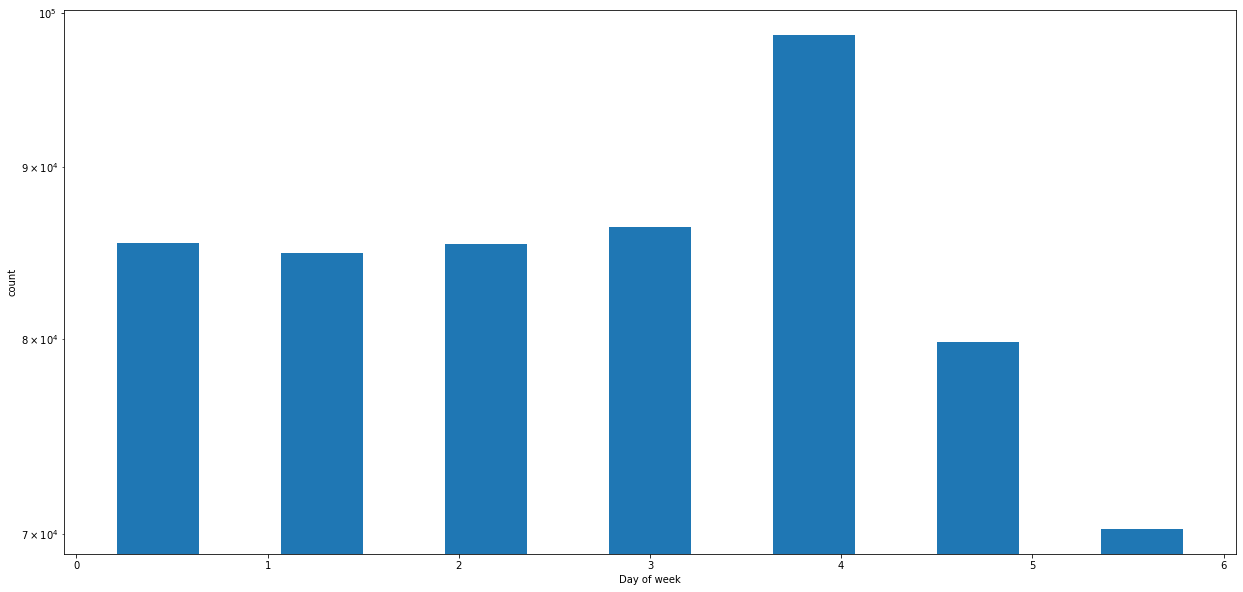

In [86]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Day of week')
ax.set_ylabel('count');
ax.set_yscale('log')
ax.hist(x=train_subset.DT_day_week, bins=7, rwidth=0.5)

The above histogram indicates an interesting thing. If we assume reference start day of week as Monday, then Friday is the day on which most number of transactions occur. This might be due to the fact that people tend to spend more ahead of the weekend. Maybe they buy stuff, or plan a trip or book a movie ticket!

(array([137321.,  92585.,  86021., 101632.,  83655.,  89326.]),
 array([12.        , 12.83333333, 13.66666667, 14.5       , 15.33333333,
        16.16666667, 17.        ]),
 <a list of 6 Patch objects>)

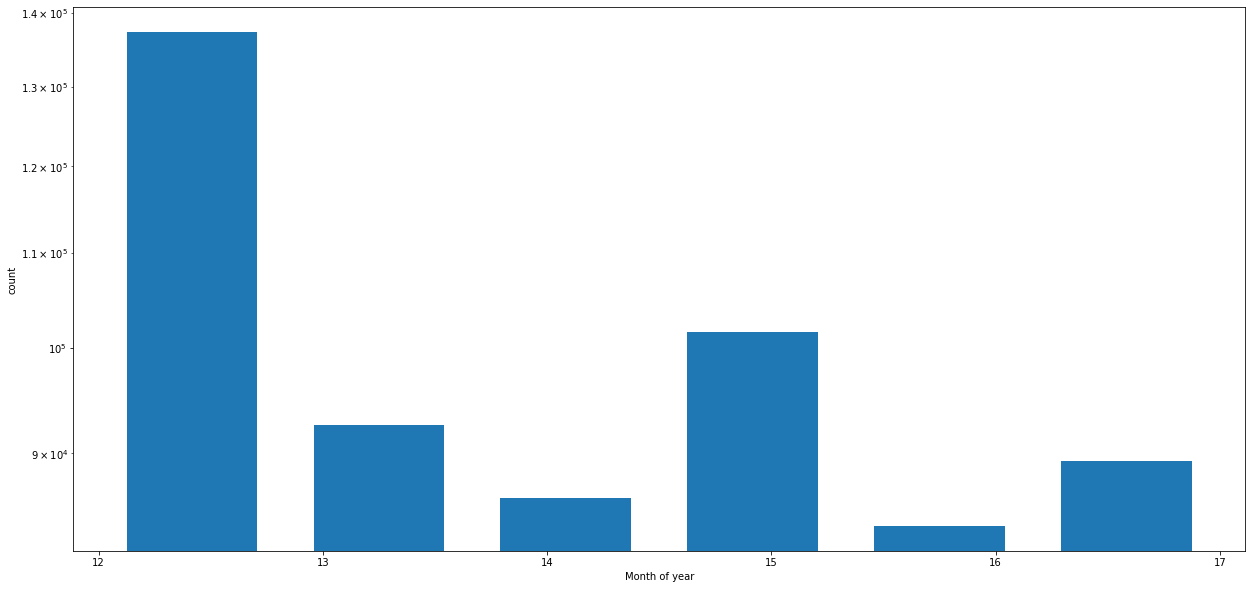

In [95]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Month from reference')
ax.set_ylabel('count');
ax.set_yscale('log')
ax.hist(x=train_subset.DT_M, bins=6, rwidth=0.7)

The histogram above shows that data is for 6 months from a reference date. Most number of transactions occur in the very first month from the reference date. Then there is a dip for next 2 months and then the transactions again increase in the fourth month. This suggests that there were some events(like festivals) in those 2 months that led to higher transaction volumes. This suggestion does seem to be true because since we have 2017-11-30 as the reference date, there are large number of transactions in the next month December - the month of Christmas! People holiday during these days and tend to spend more on food, shopping, etc.

(array([12093.,     0., 26854.,     0., 30276.,     0., 41326.,     0.,
        26772.,     0., 23029.,     0., 20466.,     0., 20367.,     0.,
        19623.,     0., 23185.,     0., 20739.,     0., 20696.,     0.,
        20901.,     0., 27314.,     0., 22575.,     0., 20733.,     0.,
        21020.,     0., 22097.,     0., 22300.,     0., 18482.,     0.,
        18613.,     0., 18652.,     0., 22071.,     0., 20726.,     0.,
        20332.,     0., 19010., 10288.]),
 array([48. , 48.5, 49. , 49.5, 50. , 50.5, 51. , 51.5, 52. , 52.5, 53. ,
        53.5, 54. , 54.5, 55. , 55.5, 56. , 56.5, 57. , 57.5, 58. , 58.5,
        59. , 59.5, 60. , 60.5, 61. , 61.5, 62. , 62.5, 63. , 63.5, 64. ,
        64.5, 65. , 65.5, 66. , 66.5, 67. , 67.5, 68. , 68.5, 69. , 69.5,
        70. , 70.5, 71. , 71.5, 72. , 72.5, 73. , 73.5, 74. ]),
 <a list of 52 Patch objects>)

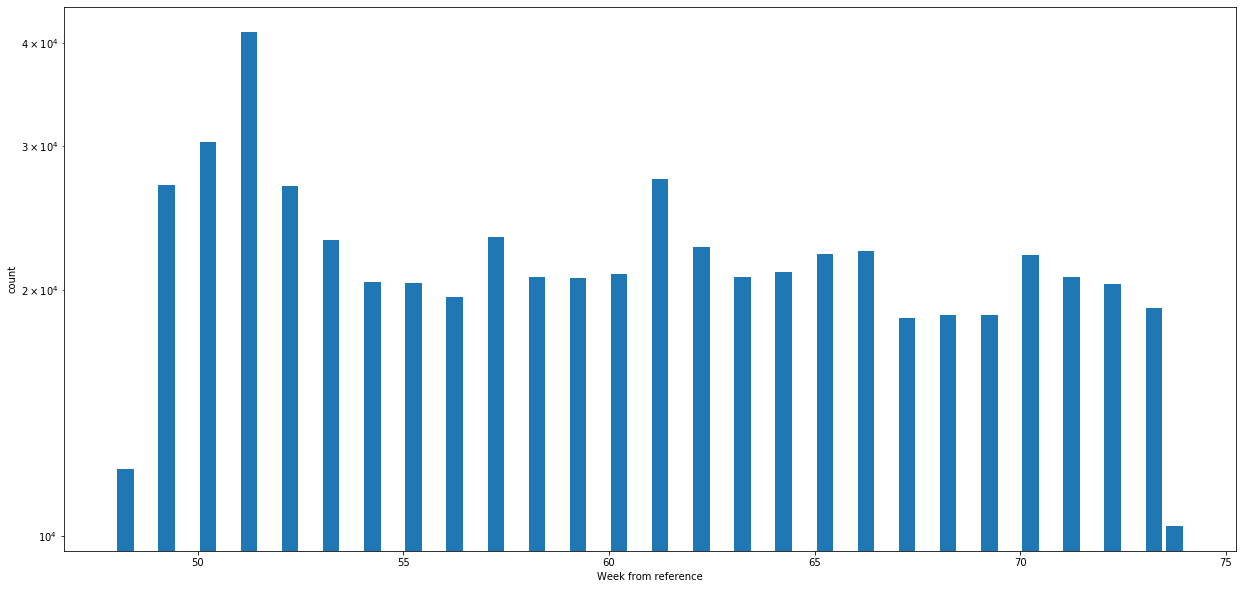

In [98]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Week from reference')
ax.set_ylabel('count');
ax.set_yscale('log')
ax.hist(x=train_subset.DT_W, bins=52, rwidth=0.8)

The above histogram also suggests the deduction that we obtained from the previous plot : people spend more around Christmas and New Year. The histogram shows large transactions during the third and fourth week after 2017-11-30 which are the weeks of Christmas and the New Year celebrations. The above 2 histograms also provide an insight that the data might be collected from countries where Christmas and New Year are celebrated on a grand scale.

From this assignment as a whole, I learnt that preprocessing, feature addition and data visualisation play a very important part in analyzing huge data. Preprocessing involves examining all the columns that have null values and either dropping them completely or filling them with some count(0 or median or anything else) for numerical columns and with 'unknown' or relevant value for categorical columns. Also, not every time the data will have meaningful columns. For eg, the TransactionDT column is just a timestamp value from a reference time and it needed to be processed to have some meaningful columns like hour, week, month, etc. Also, data aggregation is very helpful while visualising large data. For eg, aggregating all device models of the same brand gave a clearer insight into the data distribution. 

## Part 6 - Prediction Model

In [6]:
reset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
import numpy as np
from scipy.stats import norm
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
import gc, datetime, random
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold,
GridSearchCV, train_test_split, TimeSeriesSplit


train_identity = pd.read_csv(r"C:\Users\visha\Desktop\MS courses\DSF\train_identity.csv");
train_transaction = pd.read_csv(r"C:\Users\visha\Desktop\MS courses\DSF\train_transaction.csv");
test_identity = pd.read_csv(r"C:\Users\visha\Desktop\MS courses\DSF\test_identity.csv");
test_transaction = pd.read_csv(r"C:\Users\visha\Desktop\MS courses\DSF\test_transaction.csv");

train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')


def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

del train_identity, train_transaction, test_identity, test_transaction

train_subset = train[['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'addr1', 'addr2', 'dist1', 'dist2', 'DeviceType', 'DeviceInfo']]
test_subset = train[['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'addr1', 'addr2', 'dist1', 'dist2', 'DeviceType', 'DeviceInfo']]

def get_too_many_null_attr(data):
    many_null_cols = [col for col in data.columns if data[col].isnull().sum() / data.shape[0] > 0.95]
    return many_null_cols

def get_too_many_repeated_val(data):
    big_top_value_cols = [col for col in train_subset.columns if train_subset[col].value_counts(dropna=False, normalize=True).values[0] > 0.95]
    return big_top_value_cols

def get_useless_columns(data):
    too_many_null = get_too_many_null_attr(data)
    print("More than 90% null: " + str(len(too_many_null)))
    too_many_repeated = get_too_many_repeated_val(data)
    print("More than 90% repeated value: " + str(len(too_many_repeated)))
    cols_to_drop = list(set(too_many_null + too_many_repeated))
    cols_to_drop.remove('isFraud')
    return cols_to_drop

cols_to_drop = get_useless_columns(train)

train_subset['TransactionAmt'] = np.log1p(train_subset['TransactionAmt'])
test_subset['TransactionAmt'] = np.log1p(test_subset['TransactionAmt'])


emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other',
          'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft',
          'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other',
          'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo',
          'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo',
          'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo',
          'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo',
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other',
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple',
          'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other',
          'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    train_subset[c + '_bin'] = train_subset[c].map(emails)
    test_subset[c + '_bin'] = test_subset[c].map(emails)
    
    train_subset[c + '_suffix'] = train_subset[c].map(lambda x: str(x).split('.')[-1])
    test_subset[c + '_suffix'] = test_subset[c].map(lambda x: str(x).split('.')[-1])
    
    train_subset[c + '_suffix'] = train_subset[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test_subset[c + '_suffix'] = test_subset[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    
    
p = 'P_emaildomain'
r = 'R_emaildomain'
uknown = 'email_not_provided'

def setDomain(df):
    df[p] = df[p].fillna(uknown)
    df[r] = df[r].fillna(uknown)
    
    # Check if P_emaildomain matches R_emaildomain
    df['email_check'] = np.where((df[p]==df[r])&(df[p]!=uknown),1,0)

    df[p+'_prefix'] = df[p].apply(lambda x: x.split('.')[0])
    df[r+'_prefix'] = df[r].apply(lambda x: x.split('.')[0])
    
    return df
    
train_subset=setDomain(train_subset)
test_subset=setDomain(test_subset)


TARGET = 'isFraud'
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

def setTime(df):
    df['TransactionDT'] = df['TransactionDT'].fillna(df['TransactionDT'].median())
    # Temporary
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_M'] = (df['DT'].dt.year-2017)*12 + df['DT'].dt.month
    df['DT_W'] = (df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear
    df['DT_D'] = (df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day

    return df


import re
def setDevice(df):
df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]
df.loc[df['device_name'].str.contains('SM', na=False, flags=re.IGNORECASE), 'device_name'] = 'Samsung'
df.loc[df['device_name'].str.contains('SAMSUNG', na=False, flags=re.IGNORECASE), 'device_name'] = 'Samsung'
df.loc[df['device_name'].str.contains('GT-', na=False, flags=re.IGNORECASE), 'device_name'] = 'Samsung'
df.loc[df['device_name'].str.contains('Moto G', na=False, flags=re.IGNORECASE), 'device_name'] = 'Motorola'
df.loc[df['device_name'].str.contains('Moto', na=False, flags=re.IGNORECASE), 'device_name'] = 'Motorola'
df.loc[df['device_name'].str.contains('moto', na=False, flags=re.IGNORECASE), 'device_name'] = 'Motorola'
df.loc[df['device_name'].str.contains('LG-', na=False, flags=re.IGNORECASE), 'device_name'] = 'LG'
df.loc[df['device_name'].str.contains('rv:', na=False, flags=re.IGNORECASE), 'device_name'] = 'RV'
df.loc[df['device_name'].str.contains('HUAWEI', na=False, flags=re.IGNORECASE), 'device_name'] = 'Huawei'
df.loc[df['device_name'].str.contains('ALE-', na=False, flags=re.IGNORECASE), 'device_name'] = 'Huawei'
df.loc[df['device_name'].str.contains('-L', na=False, flags=re.IGNORECASE), 'device_name'] = 'Huawei'
df.loc[df['device_name'].str.contains('Blade', na=False, flags=re.IGNORECASE), 'device_name'] = 'ZTE'
df.loc[df['device_name'].str.contains('BLADE', na=False, flags=re.IGNORECASE), 'device_name'] = 'ZTE'
df.loc[df['device_name'].str.contains('Linux', na=False, flags=re.IGNORECASE), 'device_name'] = 'Linux'
df.loc[df['device_name'].str.contains('XT', na=False, flags=re.IGNORECASE), 'device_name'] = 'Sony'
df.loc[df['device_name'].str.contains('HTC', na=False, flags=re.IGNORECASE), 'device_name'] = 'HTC'
df.loc[df['device_name'].str.contains('ASUS', na=False, flags=re.IGNORECASE), 'device_name'] = 'Asus'
df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
df['had_id'] = 1
gc.collect()
return df


train_subset=setDevice(train_subset)
test_subset=setDevice(test_subset)
    
train_subset=setTime(train_subset)
test_subset=setTime(test_subset)

class ModifiedLabelEncoder(LabelEncoder):
def fit_transform(self, y, *args, **kwargs):
return super().fit_transform(y).reshape(-1, 1)
def transform(self, y, *args, **kwargs):
return super().transform(y).reshape(-1, 1)

class DataFrameSelector(BaseEstimator, TransformerMixin):
def __init__(self, attr):
self.attributes = attr
def fit(self, X, y=None):
return self
def transform(self, X):
return X[self.attributes].values

i_cols = ['addr1','addr2',
'dist1','dist2',
'P_emaildomain', 'R_emaildomain',
'DeviceInfo','device_name'
]
for col in i_cols:
    temp_df = pd.concat([train_subset[[col]], test_subset[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()
    train_subset[col+'_fq_enc'] = train_subset[col].map(fq_encode)
    test_subset[col+'_fq_enc'] = test_subset[col].map(fq_encode)
    
for col in ['DT_M','DT_W','DT_D']:
    temp_df = pd.concat([train_subset[[col]], test_subset[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()
    train_subset[col+'_total'] = train_subset[col].map(fq_encode)
    test_subset[col+'_total'] = test_subset[col].map(fq_encode)
    
    
noisy_cols = [
'TransactionID','TransactionDT',
'DT','DT_M','DT_W','DT_D',
'DT_hour','DT_day_week','DT_day',
'DT_D_total','DT_W_total','DT_M_total'
]
noisy_cat_cols = list(train_subset[noisy_cols].select_dtypes(include=['object']).columns)
noisy_num_cold = list(train_subset[noisy_cols].select_dtypes(exclude=['object']).columns)


cat_attr = list(train_subset.select_dtypes(include=['object']).columns)
num_attr = list(train_subset.select_dtypes(exclude=['object']).columns)
num_attr.remove('isFraud')


for col in noisy_cat_cols:
    if col in cat_attr:
        print("Deleting " + col)
        cat_attr.remove(col)
for col in noisy_num_cold:
    if col in num_attr:
        print("Deleting " + col)
        num_attr.remove(col)
        
        
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attr)),
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', StandardScaler()),
    ]) 

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attr)),
        ('imputer', SimpleImputer(strategy="most_frequent")),
    ])


full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])


def encodeCategorical(df_train, df_test):
    for f in df_train.drop('isFraud', axis=1).columns:
        if df_train[f].dtype=='object' or df_test[f].dtype=='object': 
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(df_train[f].values) + list(df_test[f].values))
            df_train[f] = lbl.transform(list(df_train[f].values))
            df_test[f] = lbl.transform(list(df_test[f].values))
    return df_train, df_test


y_train_subset = train_subset['isFraud']
train_subset, test_subset = encodeCategorical(train_subset, test_subset)

X_train_subset = pd.DataFrame(full_pipeline.fit_transform(train_subset))
gc.collect()


test_subset = pd.DataFrame(full_pipeline.transform(test_subset))

SEED = 42
import lightgbm as lgb

def makePredictions(tr_df, tt_df, target, lgb_params, NFOLDS=2):
    folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

    X,y = tr_df, y_train    
    P = tt_df

    predictions = np.zeros(len(tt_df))
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
        print('Fold:',fold_)
        tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx]
        vl_x, vl_y = X.iloc[val_idx,:], y[val_idx]
            
        print(len(tr_x),len(vl_x))
        tr_data = lgb.Dataset(tr_x, label=tr_y)

        vl_data = lgb.Dataset(vl_x, label=vl_y)  

        estimator = lgb.train(
            lgb_params,
            tr_data,
            valid_sets = [tr_data, vl_data],
            verbose_eval = 200,
        )   
        
        pp_p = estimator.predict(P)
        predictions += pp_p/NFOLDS
        
        del tr_x, tr_y, vl_x, vl_y, tr_data, vl_data
        gc.collect()
        
    tt_df['prediction'] = predictions
    
    return tt_df


lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.064,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':800,
                    'max_bin':255,
                    'verbose':-1,
                    'seed': SEED,
                    'early_stopping_rounds':100, 
                } 

lgb_params['learning_rate'] = 0.005
lgb_params['n_estimators'] = 1800
lgb_params['early_stopping_rounds'] = 100    
test_predictions = makePredictions(X_train, test, TARGET, lgb_params, NFOLDS=8)


lgb_submission = pd.DataFrame({
    "isFraud": test_predictions['prediction'],
})


lgb_submission.insert(0, "TransactionID", np.arange(3663549, 3663549 + 506691))
lgb_submission.to_csv('prediction.csv', index=False)

For building my model, I have used only the columns mentioned for the first five questions of this assignment. I have also derived some columns like day, week and month('DT_M','DT_W','DT_D') from the TransactionDT field. The sender and receiver's email domain have also been aggregated. Same has also been done for device info attribute so as to provide a new attribute to the model called device_name which consists of 14-15 unique values. This has been done for better prediction. I have also added new frequency columns for the following columns:

'addr1','addr2',
'dist1','dist2',
'P_emaildomain', 'R_emaildomain',
'DeviceInfo','device_name',
'DT_M','DT_W','DT_D'

The frequency addition has been done as the entire data falls in certain buckets for each of the categorical columns and hence can be grouped and used by the model. For eg, DeviceInfo has categories Mobile, Desktop and Other. The frequency of each of these values in the transactions can help predict more accurately.I have also label encoded the categorical data for both train and test datasets so that they can be used in the FeatureUnion pipeline. This pipeline uses median strategy for numerical attributes and most frequent strategy for categorical ones. For prediction, I have used LightGBM which is a gradient boosting framework that uses tree based learning algorithms. I have also used KFold cross validation that randomly shuffles the data into testing and training sets for better fir and good learning rate. For the given data, bossting type gbdt performs better than rf(Random Forest).

The AUC score for this model is 0.8551 which can further be improved by adding more columns from the base dataset and adding their frequencies as new features.

## Part 7 - Final Result

Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. Be sure to provide a link to your Kaggle profile. Make sure to include a screenshot of your ranking. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link: https://www.kaggle.com/sardavk12

Highest Rank: 5145

Score: 0.8551

Number of entries: 4

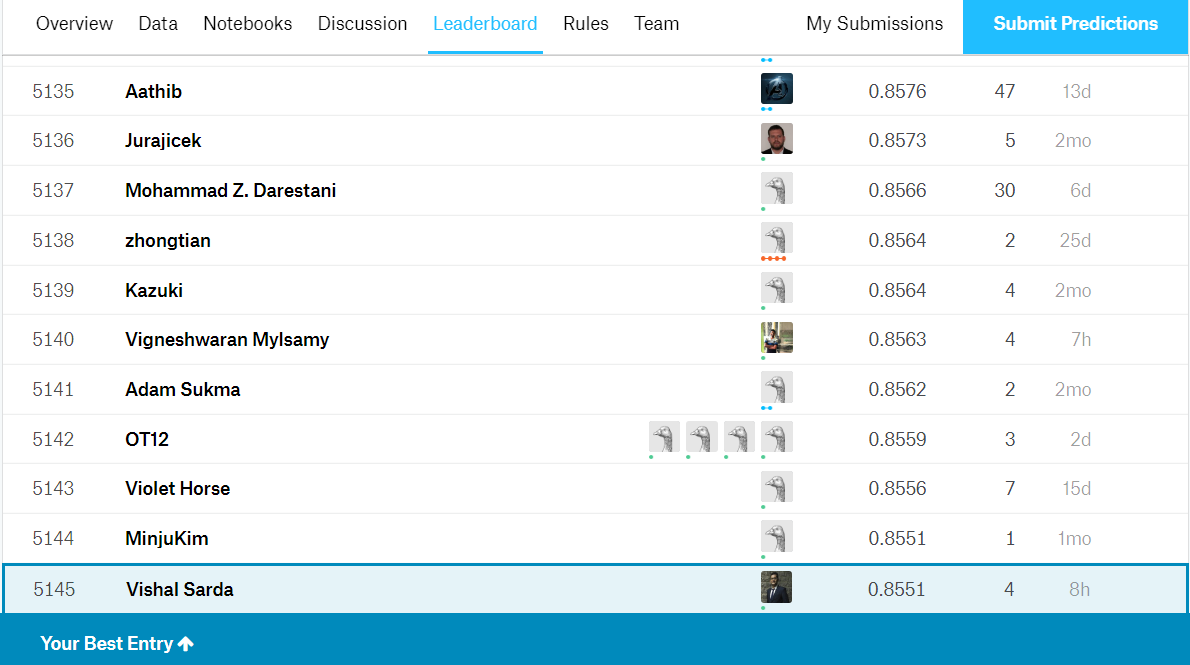